In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.colors
from tqdm import tqdm

## Plot Config

In [2]:
dataset_names = {
    "german" : "German Credit",
    "compas" : "COMPAS",
    "adult" : "Adult",
    "acsincome" : "ACSIncome",
    "taiwan" : "Taiwan Credit",
    "enem" : "ENEM",
    "enemreg" : "ENEM Reg.",
}
methods_color = {
    "LGBMClassifier" : "#ffd92f",
    "LGBMRegressor" : "#ffd92f",
    "FairGBMClassifier" : "#fc8d62",
    "FairGBMClassifier_eod" : "#fc8d62",
    "MinMaxFair" : "#a6d854",
    "MinMaxFairRegressor" : "#a6d854",
    "MinMaxFair_tpr" : "#a6d854",
    "MinMaxFairRegressor" : "#a6d854",
    "M2FGBClassifier" : "#8da0cb",
    "M2FGBClassifier_v1" : "#8da0cb",
    "M2FGBClassifier_tpr" : "#8da0cb",
    "M2FGBClassifier_pr" : "#8da0cb",
    "M2FGBRegressor" : "#8da0cb",
    "MinimaxPareto" : "pink",
    "MinimaxPareto_tpr" : "pink"
}
methods_names = {
    "LGBMClassifier" : "LGBM",
    "LGBMRegressor" : "LGBM",
    "FairGBMClassifier" : "FairGBM",
    "FairGBMClassifier_eod" : "FairGBM (eod)",
    "M2FGBClassifier_tpr" : "M²FGB (tpr)",
    "M2FGBClassifier_pr" : "M²FGB (pr)",
    "M2FGBClassifier" : "M²FGB",
    "M2FGBRegressor" : "M²FGB",
    "MinMaxFair" : "MinMaxFair",
    "MinMaxFair_tpr" : "MinMaxFair (tpr)",
    "MinimaxPareto" : "MMPF",
    "MinimaxPareto_tpr" : "MMPF (tpr)",
    "MinMaxFairRegressor" : "MinMaxFair",
}

handles = [
    Line2D([0], [0], marker = "o", color = "w", label=value, markerfacecolor=methods_color[key], markersize=10) for key, value in methods_names.items() if "tpr" not in key and "pr" not in key and "eod" not in key
]

handles_tpr = [
    Line2D([0], [0], marker = "o", color = "w", label=value, markerfacecolor=methods_color[key], markersize=10) for key, value in methods_names.items() if "tpr" in key or "LGBMClassifier" in key or "eod" in key
]
handles_pr = [
    Line2D([0], [0], marker = "o", color = "w", label=value, markerfacecolor=methods_color[key], markersize=10) for key, value in methods_names.items() if "_pr" in key or "LGBM" in key
]

handles_reg = [
    Line2D([0], [0], marker = "o", color = "w", label=value, markerfacecolor=methods_color[key], markersize=10) for key, value in methods_names.items() if "Regressor" in key
]

In [3]:
SEED = 0
np.random.seed(SEED)

## Convergence Plots

In [5]:
import sys
sys.path.append("../scripts")
import data
import models
import utils

In [5]:
args = {
    "dataset" : "german",
    "n_groups" : 4,
}
X_train, A_train, Y_train, X_val, A_val, Y_val, X_test, A_test, Y_test = (
    data.get_strat_split(args["dataset"], args["n_groups"], 20, SEED)
)

{'Male,Older 30': 0, 'Female,Under 30': 1, 'Male,Under 30': 2, 'Female,Older 30': 3}


In [6]:
params = {
    "learning_rate" : 0.05,
    "max_depth" : 3,
    "min_child_weight" : 1e-3,
    #"reg_lambda" : 1000
}

In [9]:
def call_model(iter, method):
    if method == "m2fgb":
        return models.M2FGBClassifier(
            multiplier_learning_rate=0.05,
            fair_weight=0.5,
            n_estimators=iter,
            fairness_constraint="true_positive_rate",
            random_state=SEED,
            **params
        )
    elif method == "lgbm":
        return models.M2FGBClassifier(
            multiplier_learning_rate=0.01,
            fair_weight=0,
            n_estimators=iter,
            fairness_constraint="true_positive_rate",
            random_state=SEED,
            **params
        )


iters_list = list(range(5, 100, 5))
methods_names = ["lgbm", "m2fgb"]
score = {}
score["train"] = dict([(m, []) for m in methods_names])
score["test"] = dict([(m, []) for m in methods_names])
computing_time = dict([(m, 0) for m in methods_names])

for method in methods_names:
    for iter in tqdm(iters_list):
        model = call_model(iter, method)
        #start = time()
        model.fit(X_train, Y_train, A_train)
        #end = time()

        #computing_time[method] = end - start

        Y_pred = model.predict_proba(X_train)[:, 1]
        score["train"][method].append(utils.logloss_group(Y_train, Y_pred, A_train, "true_positive_rate"))
        
        Y_pred = model.predict_proba(X_test)[:, 1]
        score["test"][method].append(utils.logloss_group(Y_test, Y_pred, A_test, "true_positive_rate"))

    score["train"][method] = np.array(score["train"][method])
    score["test"][method] = np.array(score["test"][method])


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 14.24it/s]


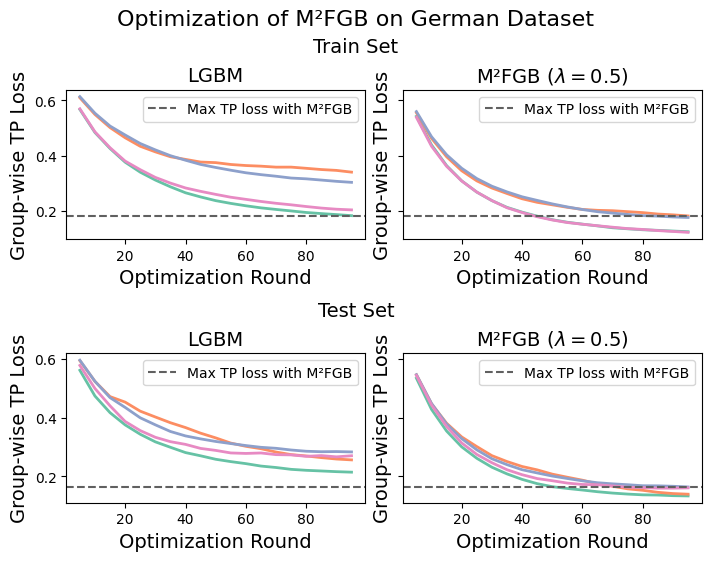

In [20]:
fig = plt.figure(constrained_layout=True, figsize = (7, 5.5))
fig.suptitle('Optimization of M²FGB on German Dataset', fontsize = 16)

subfigs = fig.subfigures(nrows=2, ncols=1)
sets = ["train", "test"]
set_names = ["Train Set", "Test Set"]
better_methods_names = {
    "lgbm" : "LGBM",
    "m2fgb" : "M²FGB ($\lambda = 0.5$)"
}
for row, subfig in enumerate(subfigs):
    subfig.suptitle(set_names[row], fontsize = 14)

    max_score = np.max(score[sets[row]]["m2fgb"][-1, :])
    axs = subfig.subplots(nrows=1, ncols=2, sharey=True)


    for col, ax in enumerate(axs):
        method = methods_names[col]

        ax.set_title(better_methods_names[method], fontsize = 14)

        # set color cycle to Pastel2
        ax.set_prop_cycle(color=plt.cm.Set2.colors)
        
        for ng in range(args["n_groups"]):
            ax.plot(iters_list, score[sets[row]][method][:, ng], lw = 2)


        ax.set_xlabel("Optimization Round", fontsize = 14)
        ax.set_ylabel("Group-wise TP Loss", fontsize = 14)

        ax.axhline(max_score, color = "#606060", linestyle = "--", label = "Max TP loss with M²FGB")
        ax.legend(loc = "upper right")
        #ax.grid(True)

plt.savefig("../figs/convergence_german.pdf", dpi = 300)
plt.show()

## $\lambda$ parameter

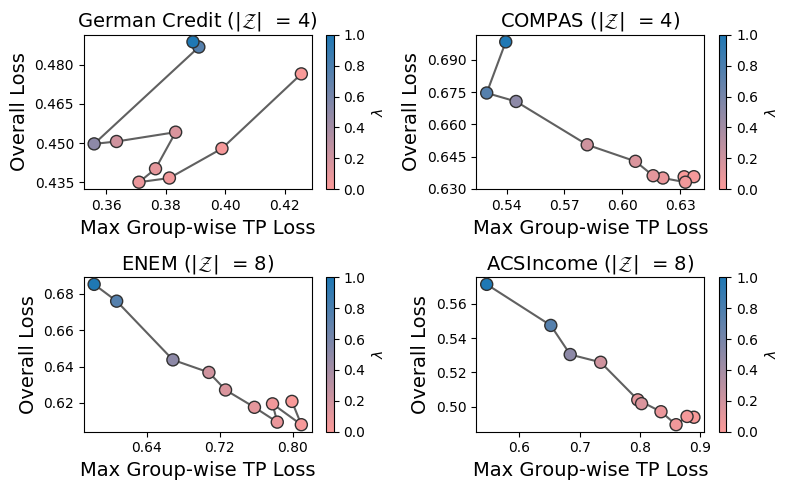

In [23]:
norm=matplotlib.colors.Normalize(0, 1)
#norm=matplotlib.colors.Normalize(0,0.5)
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["#fb9a99","#1f78b4"])

fig, axs = plt.subplots(nrows =2, ncols = 2, figsize = (8, 5))
axs = axs.flatten()

for i, dataset in enumerate(["german_4", "compas_4", "enem_8", "acsincome_8"]):
    n_groups = int(dataset.split("_")[1])
    

    try:
        results = pd.read_csv(f"../results_aaai/experiment_new/fair_weight/{dataset}g/M2FGBClassifier_tpr/train.csv")
        trials = pd.read_csv(f"../results_aaai/experiment_new/fair_weight/{dataset}g/M2FGBClassifier_tpr/trials.csv")
        results = results.merge(trials)

        results["fair_weight"] = results.params_fair_weight
        results = results.loc[:, results.dtypes == "float"].groupby("fair_weight").mean().reset_index()

        
        
        
        cm = axs[i].scatter(
            results.max_logloss_tpr,
            results.logloss,
            c = results.fair_weight,
            cmap = cmap,
            norm = norm,
            zorder = 100,
            s = 75,
            ec = "#303030",
        )

        axs[i].plot(
            results.max_logloss_tpr,
            results.logloss,
            c = "#606060",
        )

    except:
        pass 

    dataset = dataset.split("_")[0]

    axs[i].set_xlabel("Max Group-wise TP Loss", fontsize = 14)
    axs[i].set_ylabel("Overall Loss", fontsize = 14)

    axs[i].set_title(dataset_names[dataset] + " (|$\mathcal{Z}$|  " + f"= {n_groups})", fontsize = 14)

    # make x and y axis only have 4 ticks each
    axs[i].xaxis.set_major_locator(plt.MaxNLocator(4))
    axs[i].yaxis.set_major_locator(plt.MaxNLocator(5))
    # add colorbar
    fig.colorbar(cm, ax=axs[i], label="$\lambda$")

plt.tight_layout()

plt.savefig("../figs/fair_weight.pdf", dpi = 300)
plt.show()

## Benchmark Datasets

In [4]:
import scipy.stats

def calculate_interval(samples, confidence=0.95):
    n = len(samples)
    m, se = np.mean(samples), scipy.stats.sem(samples)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return h

In [40]:
def summary_experiment(
    perf_metric,
    fair_metric,
    dataset_list,
    method_list,
    experiment_folder = "../results_aaai/experiment",
    n_sampled = 100,
    n_repetitions = 1000,
    maximize = True,
):

    alpha_list = [i/20 for i in range(21)]
    df_results = []
    
    for dataset in dataset_list:
        for model in method_list:
            try:
                results_val = pd.read_csv(f"{experiment_folder}/{dataset}/{model}/val.csv")
                results_test = pd.read_csv(f"{experiment_folder}/{dataset}/{model}/test.csv")
                np.random.seed(SEED)
                selections = np.random.choice(len(results_val), size = (len(alpha_list), n_repetitions, n_sampled), replace = True)

                print(f"Total models for {model}, {dataset} : {len(results_val)}")
                results_val["duration"] = pd.to_timedelta(results_val["duration"]).dt.total_seconds()
                results_test["duration"] = pd.to_timedelta(results_test["duration"]).dt.total_seconds()

                for i, alpha in tqdm(enumerate(alpha_list), total = len(alpha_list)):
                    for j in range(n_repetitions):
                        # sample models
                        results_val_sample = results_val.iloc[selections[i, j]]
                        score = alpha * results_val_sample[fair_metric] + (1 - alpha) * results_val_sample[perf_metric]

                        if maximize:
                            best_model = results_test.loc[score.idxmax()]
                        else:
                            best_model = results_test.loc[score.idxmin()]

                        df_results.append({
                            "dataset" : dataset,
                            "model" : model,
                            "alpha" : alpha,
                            perf_metric : best_model[perf_metric],
                            fair_metric : best_model[fair_metric],
                            "score" : best_model[perf_metric] * (1 - alpha) + best_model[fair_metric] * alpha,
                            "duration" : best_model.duration,
                        })
            except:
               print(f"Error in {model}, {dataset}")
    df_results = pd.DataFrame(df_results)
    df_results = df_results.groupby(["dataset", "model", "alpha"]).agg({
        "duration" : ["mean", "std", calculate_interval],
        perf_metric : ["mean", "std", calculate_interval],
        fair_metric : ["mean", "std", calculate_interval],
        "score" : ["mean", "std", calculate_interval],
    }).reset_index()
    df_results.columns = ["_".join(col).strip() for col in df_results.columns.values]
    df_results = df_results.rename(columns = {
        "dataset_" : "dataset",
        "model_" : "model",
        "alpha_" : "alpha",
        "duration_mean" : "duration",
        "duration_std" : "duration_std",
        "duration_calculate_interval" : "duration_interval",
        f"{perf_metric}_mean" : f"{perf_metric}",
        f"{perf_metric}_std" : f"{perf_metric}_std",
        f"{perf_metric}_calculate_interval" : f"{perf_metric}_interval",
        f"{fair_metric}_mean" : f"{fair_metric}",
        f"{fair_metric}_std" : f"{fair_metric}_std",
        f"{fair_metric}_calculate_interval" : f"{fair_metric}_interval",
        "score_mean" : "score",
        "score_std" : "score_std",
        "score_calculate_interval" : "score_interval",})
    return df_results

In [6]:
def plot_results(axs, df_results, perf_metric, fair_metric):
    model_list = df_results.model.unique()
    for i, model in enumerate(model_list):
        df_results_filter = df_results[df_results.model == model]
        #df_results_filter_std = df_results_std[df_results_std.model == model]

        axs[0].plot(
            df_results_filter.alpha,
            df_results_filter[perf_metric],
            c = methods_color[model],
            lw = 2,
            zorder = 100 if "M2FGB" in model else 1,
        )
        axs[0].set_ylabel(perf_metric)
        axs[0].set_xlabel("alpha")

        axs[0].fill_between(
            df_results_filter.alpha,
            df_results_filter[perf_metric] - df_results_filter[perf_metric + "_interval"],
            df_results_filter[perf_metric] + df_results_filter[perf_metric + "_interval"],
            color = methods_color[model],
            alpha = 0.2,
        )


        axs[1].plot(
            df_results_filter.alpha,
            df_results_filter[fair_metric],
            lw = 2,
            c = methods_color[model],
            zorder = 100 if "M2FGB" in model else 1,
        )
        axs[1].set_ylabel(fair_metric)
        axs[1].set_xlabel("alpha")

        axs[1].fill_between(
            df_results_filter.alpha,
            df_results_filter[fair_metric] - df_results_filter[fair_metric + "_interval"],
            df_results_filter[fair_metric] + df_results_filter[fair_metric + "_interval"],
            color = methods_color[model],
            alpha = 0.2,
        )

        
        axs[2].scatter(
            df_results_filter[perf_metric],
            df_results_filter[fair_metric],
            c = methods_color[model],
            label = model,
            s = 60,
            ec = "#eeeeee",
            zorder = 100 if "M2FGB" in model else 1,
        )
        axs[2].set_xlabel(perf_metric)
        axs[2].set_ylabel(fair_metric)

## EQ Loss

In [36]:
perf_metric = "acc"
fair_metric = "min_acc"
dataset_list = ["german_4g", "compas_4g", "enem_8g", "acsincome_8g"]
method_list = ["M2FGBClassifier",  "MinMaxFair", "LGBMClassifier", "FairGBMClassifier", "MinimaxPareto"]
df_results = summary_experiment(
    perf_metric,
    fair_metric,
    dataset_list,
    method_list,
)

Total models for M2FGBClassifier, german_4g : 1000


  0%|                                                                                                             | 0/21 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:14<00:00,  1.45it/s]


Total models for MinMaxFair, german_4g : 1000


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:14<00:00,  1.44it/s]


Total models for LGBMClassifier, german_4g : 1000


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:14<00:00,  1.45it/s]


Total models for FairGBMClassifier, german_4g : 1000


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:14<00:00,  1.46it/s]


Total models for MinimaxPareto, german_4g : 1000


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:14<00:00,  1.45it/s]


Total models for M2FGBClassifier, compas_4g : 1000


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:14<00:00,  1.44it/s]


Total models for MinMaxFair, compas_4g : 1000


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:14<00:00,  1.45it/s]


Total models for LGBMClassifier, compas_4g : 1000


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:14<00:00,  1.45it/s]


Total models for FairGBMClassifier, compas_4g : 1000


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:14<00:00,  1.45it/s]


Total models for MinimaxPareto, compas_4g : 1000


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:14<00:00,  1.46it/s]


Total models for M2FGBClassifier, enem_8g : 1000


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:14<00:00,  1.45it/s]


Total models for MinMaxFair, enem_8g : 1000


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:14<00:00,  1.45it/s]


Total models for LGBMClassifier, enem_8g : 1000


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:14<00:00,  1.47it/s]


Total models for FairGBMClassifier, enem_8g : 1000


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:14<00:00,  1.45it/s]


Total models for MinimaxPareto, enem_8g : 1000


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:14<00:00,  1.47it/s]


Total models for M2FGBClassifier, acsincome_8g : 500


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:14<00:00,  1.46it/s]


Total models for MinMaxFair, acsincome_8g : 500


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:14<00:00,  1.45it/s]


Total models for LGBMClassifier, acsincome_8g : 500


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:14<00:00,  1.45it/s]


Total models for FairGBMClassifier, acsincome_8g : 500


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:14<00:00,  1.46it/s]


Error in MinimaxPareto, acsincome_8g


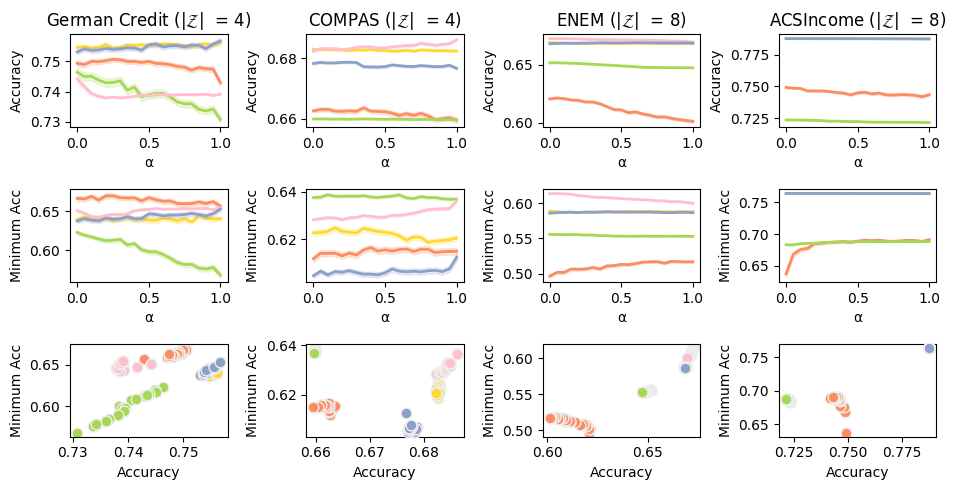

In [37]:
fig, axs = plt.subplots(nrows = 3, ncols = len(dataset_list), figsize = (2.4 * len(dataset_list), 5))
if len(dataset_list) == 1:
    axs = np.array(axs).reshape(-1, 1)

for i, dataset in enumerate(dataset_list):
    plot_results(axs[:, i], df_results[df_results.dataset == dataset], perf_metric, fair_metric)
    n_groups = int(dataset.split("_")[1][:-1])
    dataset = dataset.split("_")[0]
    axs[0, i].set_title(dataset_names[dataset] + " (|$\mathcal{Z}$|  " + f"= {n_groups})")
    for j in range(2):
        axs[j, i].set_xlabel("α")
        #axs[j, i].set_xlim(0, 0.7)
    axs[0, i].set_ylabel("Accuracy")
    axs[1, i].set_ylabel("Minimum Acc")

    axs[2, i].set_xlabel("Accuracy")
    axs[2, i].set_ylabel("Minimum Acc")

plt.tight_layout()
plt.savefig("../figs/bench_eq.pdf", dpi = 300)

## PR

In [7]:
perf_metric = "acc"
fair_metric = "min_pr"
dataset_list = ["german_4g", "compas_4g", "enem_8g", "acsincome_8g"]
method_list = ["M2FGBClassifier",  "LGBMClassifier"]
df_results = summary_experiment(
    perf_metric,
    fair_metric,
    dataset_list,
    method_list,
    use_best_model=True,
)

Total models for M2FGBClassifier, german_4g : 1000


  0%|                                                                                                                              | 0/21 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:14<00:00,  1.45it/s]


Total models for LGBMClassifier, german_4g : 1000


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:14<00:00,  1.46it/s]


Total models for M2FGBClassifier, compas_4g : 1000


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:14<00:00,  1.47it/s]


Total models for LGBMClassifier, compas_4g : 1000


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:14<00:00,  1.46it/s]


Total models for M2FGBClassifier, enem_8g : 1000


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:14<00:00,  1.47it/s]


Total models for LGBMClassifier, enem_8g : 1000


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:14<00:00,  1.47it/s]


Total models for M2FGBClassifier, acsincome_8g : 500


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:14<00:00,  1.47it/s]


Total models for LGBMClassifier, acsincome_8g : 500


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:14<00:00,  1.46it/s]


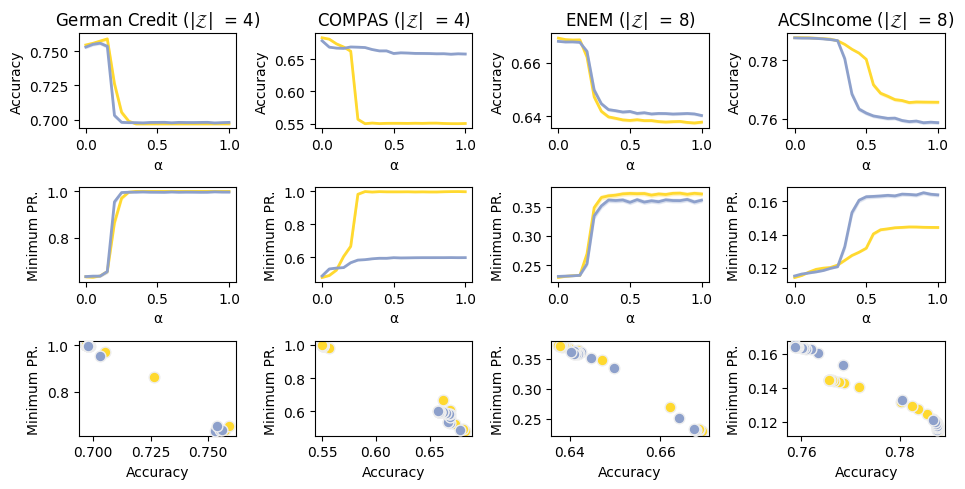

In [8]:
fig, axs = plt.subplots(nrows = 3, ncols = len(dataset_list), figsize = (2.4 * len(dataset_list), 5))
if len(dataset_list) == 1:
    axs = np.array(axs).reshape(-1, 1)

for i, dataset in enumerate(dataset_list):
    plot_results(axs[:, i], df_results[df_results.dataset == dataset], perf_metric, fair_metric)
    n_groups = int(dataset.split("_")[1][:-1])
    dataset = dataset.split("_")[0]
    axs[0, i].set_title(dataset_names[dataset] + " (|$\mathcal{Z}$|  " + f"= {n_groups})")
    for j in range(2):
        axs[j, i].set_xlabel("α")
        #axs[j, i].set_xlim(0, 0.7)
    axs[0, i].set_ylabel("Accuracy")
    axs[1, i].set_ylabel("Minimum PR.")

    axs[2, i].set_xlabel("Accuracy")
    axs[2, i].set_ylabel("Minimum PR.")

plt.tight_layout()
plt.savefig("../figs/bench_pr.pdf", dpi = 300)

## TPR

In [57]:
perf_metric = "acc"
fair_metric = "min_tpr"
dataset_list = ["german_4g", "compas_4g", "enem_8g", "acsincome_8g"]
method_list = ["M2FGBClassifier_tpr",  "MinMaxFair_tpr", "LGBMClassifier", "FairGBMClassifier_eod", "MinimaxPareto_tpr"]
df_results = summary_experiment(
    perf_metric,
    fair_metric,
    dataset_list,
    method_list,
)

Total models for M2FGBClassifier_tpr, german_4g : 1000


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:14<00:00,  1.44it/s]


Total models for MinMaxFair_tpr, german_4g : 1000


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:14<00:00,  1.45it/s]


Total models for LGBMClassifier, german_4g : 1000


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:14<00:00,  1.45it/s]


Total models for FairGBMClassifier_eod, german_4g : 1000


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:14<00:00,  1.45it/s]


Total models for MinimaxPareto_tpr, german_4g : 1000


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:14<00:00,  1.46it/s]


Total models for M2FGBClassifier_tpr, compas_4g : 1000


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:14<00:00,  1.46it/s]


Total models for MinMaxFair_tpr, compas_4g : 1000


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:14<00:00,  1.45it/s]


Total models for LGBMClassifier, compas_4g : 1000


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:14<00:00,  1.45it/s]


Total models for FairGBMClassifier_eod, compas_4g : 1000


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:14<00:00,  1.46it/s]


Total models for MinimaxPareto_tpr, compas_4g : 1000


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:14<00:00,  1.45it/s]


Total models for M2FGBClassifier_tpr, enem_8g : 1000


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:14<00:00,  1.45it/s]


Total models for MinMaxFair_tpr, enem_8g : 1000


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:14<00:00,  1.46it/s]


Total models for LGBMClassifier, enem_8g : 1000


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:14<00:00,  1.46it/s]


Total models for FairGBMClassifier_eod, enem_8g : 1000


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:14<00:00,  1.46it/s]


Total models for MinimaxPareto_tpr, enem_8g : 1000


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:14<00:00,  1.45it/s]


Total models for M2FGBClassifier_tpr, acsincome_8g : 500


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:14<00:00,  1.45it/s]


Total models for MinMaxFair_tpr, acsincome_8g : 500


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:14<00:00,  1.46it/s]


Total models for LGBMClassifier, acsincome_8g : 500


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:14<00:00,  1.45it/s]


Total models for FairGBMClassifier_eod, acsincome_8g : 500


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:14<00:00,  1.45it/s]


Error in MinimaxPareto_tpr, acsincome_8g


### Computing Cost

In [42]:
computing_cost = df_results[df_results.alpha == .0]
for dataset in dataset_list:
    print(dataset)
    baseline = computing_cost.loc[(computing_cost.dataset == dataset) & (computing_cost.model == "LGBMClassifier"), "duration"].values[0]
    for method in method_list:
        try:
        
            method_duration = computing_cost.loc[(computing_cost.dataset == dataset) & (computing_cost.model == method), "duration"].values[0]
            print(f"{method} : {np.round(method_duration / baseline, 1)}")
        except:
            pass

    print("\n")

german_4g
M2FGBClassifier_tpr : 2.4
MinMaxFair_tpr : 16.7
LGBMClassifier : 1.0
FairGBMClassifier_eod : 1.0
MinimaxPareto_tpr : 29.8


compas_4g
M2FGBClassifier_tpr : 1.5
MinMaxFair_tpr : 35.0
LGBMClassifier : 1.0
FairGBMClassifier_eod : 1.8
MinimaxPareto_tpr : 15.9


enem_8g
M2FGBClassifier_tpr : 2.3
MinMaxFair_tpr : 14.6
LGBMClassifier : 1.0
FairGBMClassifier_eod : 0.7
MinimaxPareto_tpr : 14.0


acsincome_8g
M2FGBClassifier_tpr : 2.2
MinMaxFair_tpr : 23.4
LGBMClassifier : 1.0
FairGBMClassifier_eod : 1.0




### Plots

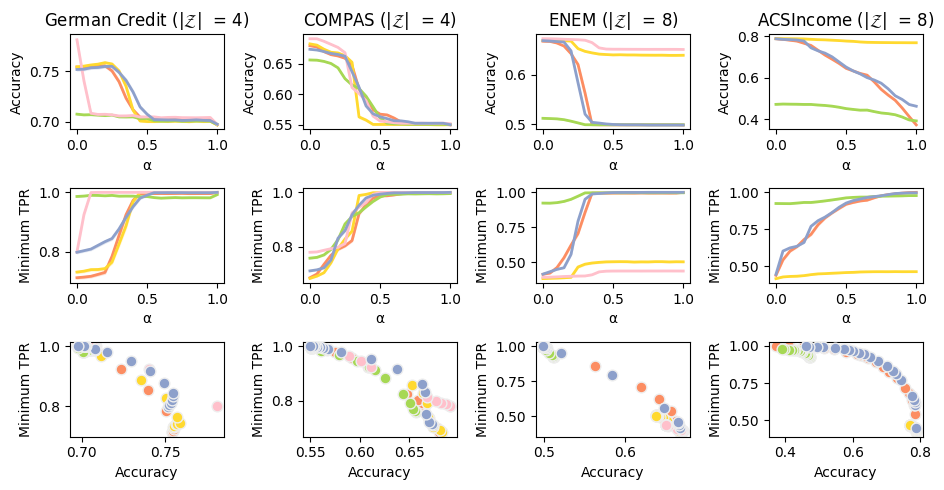

In [9]:
fig, axs = plt.subplots(nrows = 3, ncols = len(dataset_list), figsize = (2.4 * len(dataset_list), 5))
if len(dataset_list) == 1:
    axs = np.array(axs).reshape(-1, 1)

for i, dataset in enumerate(dataset_list):
    plot_results(axs[:, i], df_results[df_results.dataset == dataset], perf_metric, fair_metric)
    n_groups = int(dataset.split("_")[1][:-1])
    dataset = dataset.split("_")[0]
    axs[0, i].set_title(dataset_names[dataset] + " (|$\mathcal{Z}$|  " + f"= {n_groups})")
    for j in range(2):
        axs[j, i].set_xlabel("α")
        #axs[j, i].set_xlim(0, 0.7)
    axs[0, i].set_ylabel("Accuracy")
    axs[1, i].set_ylabel("Minimum TPR")

    axs[2, i].set_xlabel("Accuracy")
    axs[2, i].set_ylabel("Minimum TPR")

plt.tight_layout()
plt.savefig("../figs/bench_tpr.pdf", dpi = 300)

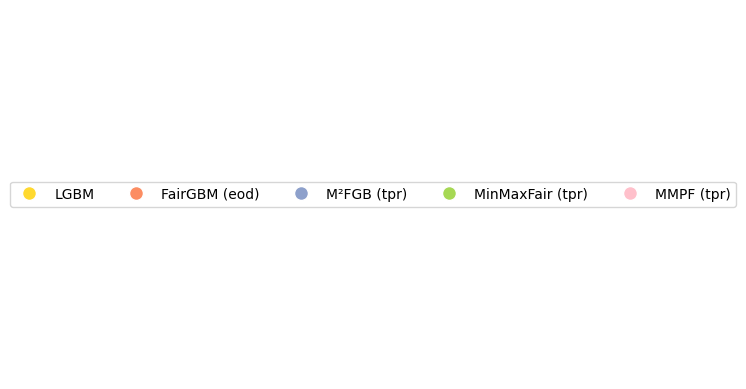

In [43]:
# plot the legend separately
fig, ax = plt.subplots()
ax.legend(handles = handles_tpr, loc = "center", ncol = len(handles_tpr), fontsize = 10)
ax.axis("off")
plt.savefig("../figs/legend_tpr.pdf", dpi = 300)

### Tables

In [58]:
df_results_temp = df_results[df_results.alpha == 0.0][["dataset", "model", "acc", "acc_std", "min_tpr", "min_tpr_std"]]
df_results_temp.round(2)

,dataset,model,acc,acc_std,min_tpr,min_tpr_std
0,acsincome_8g,FairGBMClassifier_eod,0.79,0.00,0.44,0.03
21,acsincome_8g,LGBMClassifier,0.79,0.00,0.42,0.00
42,acsincome_8g,M2FGBClassifier_tpr,0.79,0.00,0.45,0.03
63,acsincome_8g,MinMaxFair_tpr,0.47,0.02,0.92,0.03
84,compas_4g,FairGBMClassifier_eod,0.68,0.00,0.69,0.03
105,compas_4g,LGBMClassifier,0.68,0.00,0.68,0.02
126,compas_4g,M2FGBClassifier_tpr,0.67,0.01,0.71,0.02
147,compas_4g,MinMaxFair_tpr,0.66,0.01,0.76,0.02
168,compas_4g,MinimaxPareto_tpr,0.69,0.00,0.78,0.01
189,enem_8g,FairGBMClassifier_eod,0.67,0.00,0.41,0.02


### MSE

In [10]:
perf_metric = "mse"
fair_metric = "max_mse"
dataset_list = ["enemreg_8g"]
method_list = ["M2FGBRegressor", "LGBMRegressor", "MinMaxFairRegressor"]
df_results = summary_experiment(
    perf_metric,
    fair_metric,
    dataset_list,
    method_list,
    maximize=False,
)

Total models for M2FGBRegressor, enemreg_8g : 1000


0it [00:00, ?it/s]

21it [00:14,  1.45it/s]


Total models for LGBMRegressor, enemreg_8g : 1000


21it [00:14,  1.45it/s]


Total models for MinMaxFairRegressor, enemreg_8g : 1000


21it [00:14,  1.45it/s]


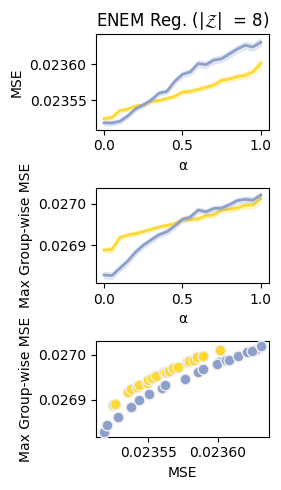

In [11]:
df_results_temp = df_results[df_results.model != "MinMaxFairRegressor"]


fig, axs = plt.subplots(nrows = 3, ncols = len(dataset_list), figsize = (3 * len(dataset_list), 5))
if len(dataset_list) == 1:
    axs = np.array(axs).reshape(-1, 1)

for i, dataset in enumerate(dataset_list):
    plot_results(axs[:, i], df_results_temp[df_results_temp.dataset == dataset], perf_metric, fair_metric)
    n_groups = int(dataset.split("_")[1][:-1])
    dataset = dataset.split("_")[0]
    axs[0, i].set_title(dataset_names[dataset] + " (|$\mathcal{Z}$|  " + f"= {n_groups})")
    for j in range(3):
        axs[j, i].set_xlabel("α")
    axs[0, i].set_ylabel("MSE")
    axs[1, i].set_ylabel("Max Group-wise MSE")

    axs[2, i].set_xlabel("MSE")
    axs[2, i].set_ylabel("Max Group-wise MSE")
plt.tight_layout()
plt.savefig("../figs/bench_mse_v1.pdf", dpi = 300)

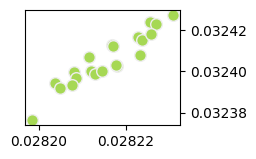

In [12]:
df_results_mmfair = df_results.copy()
df_results_mmfair = df_results_mmfair[df_results_mmfair.model == "MinMaxFairRegressor"]

fig, ax = plt.subplots(figsize = (2, 1.5))

ax.scatter(
    df_results_mmfair[perf_metric],
    df_results_mmfair[fair_metric],
    c = methods_color["MinMaxFairRegressor"],
    s = 70,
    ec = "#eeeeee",
)
ax.yaxis.tick_right()
plt.savefig("../figs/bench_mse_v2.pdf", dpi = 300)

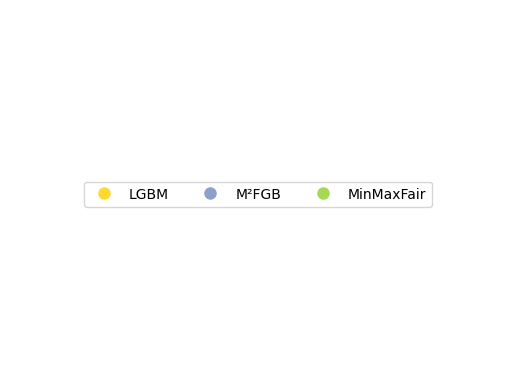

In [26]:
# plot the legend separately
fig, ax = plt.subplots()
ax.legend(handles = handles_reg, loc = "center", ncol = len(handles_tpr), fontsize = 10)
ax.axis("off")
plt.savefig("../figs/legend_reg.pdf", dpi = 300)